In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

from utils.models import strong_model_factory, weak_model_factory
from utils.tools import load_obj, summarize_posterior

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic


%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model_data = load_obj('data/bootstrap_data')

yobs = model_data['Yobs']
subject_ids = model_data['subject_ids']
y = model_data['y_est']
times = model_data['times']

with strong_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 4 chains, 0 divergences:  90%|████████▉ | 7190/8000 [00:59<00:05, 151.24draws/s]

In [66]:
df = pd.DataFrame({'yobs':yobs,
                   'y':y,
                   'times':times,
                   'subject_ids':subject_ids})

predictions = summarize_posterior(data, 'y_est', 'pred')

dfpred = df.join(predictions)

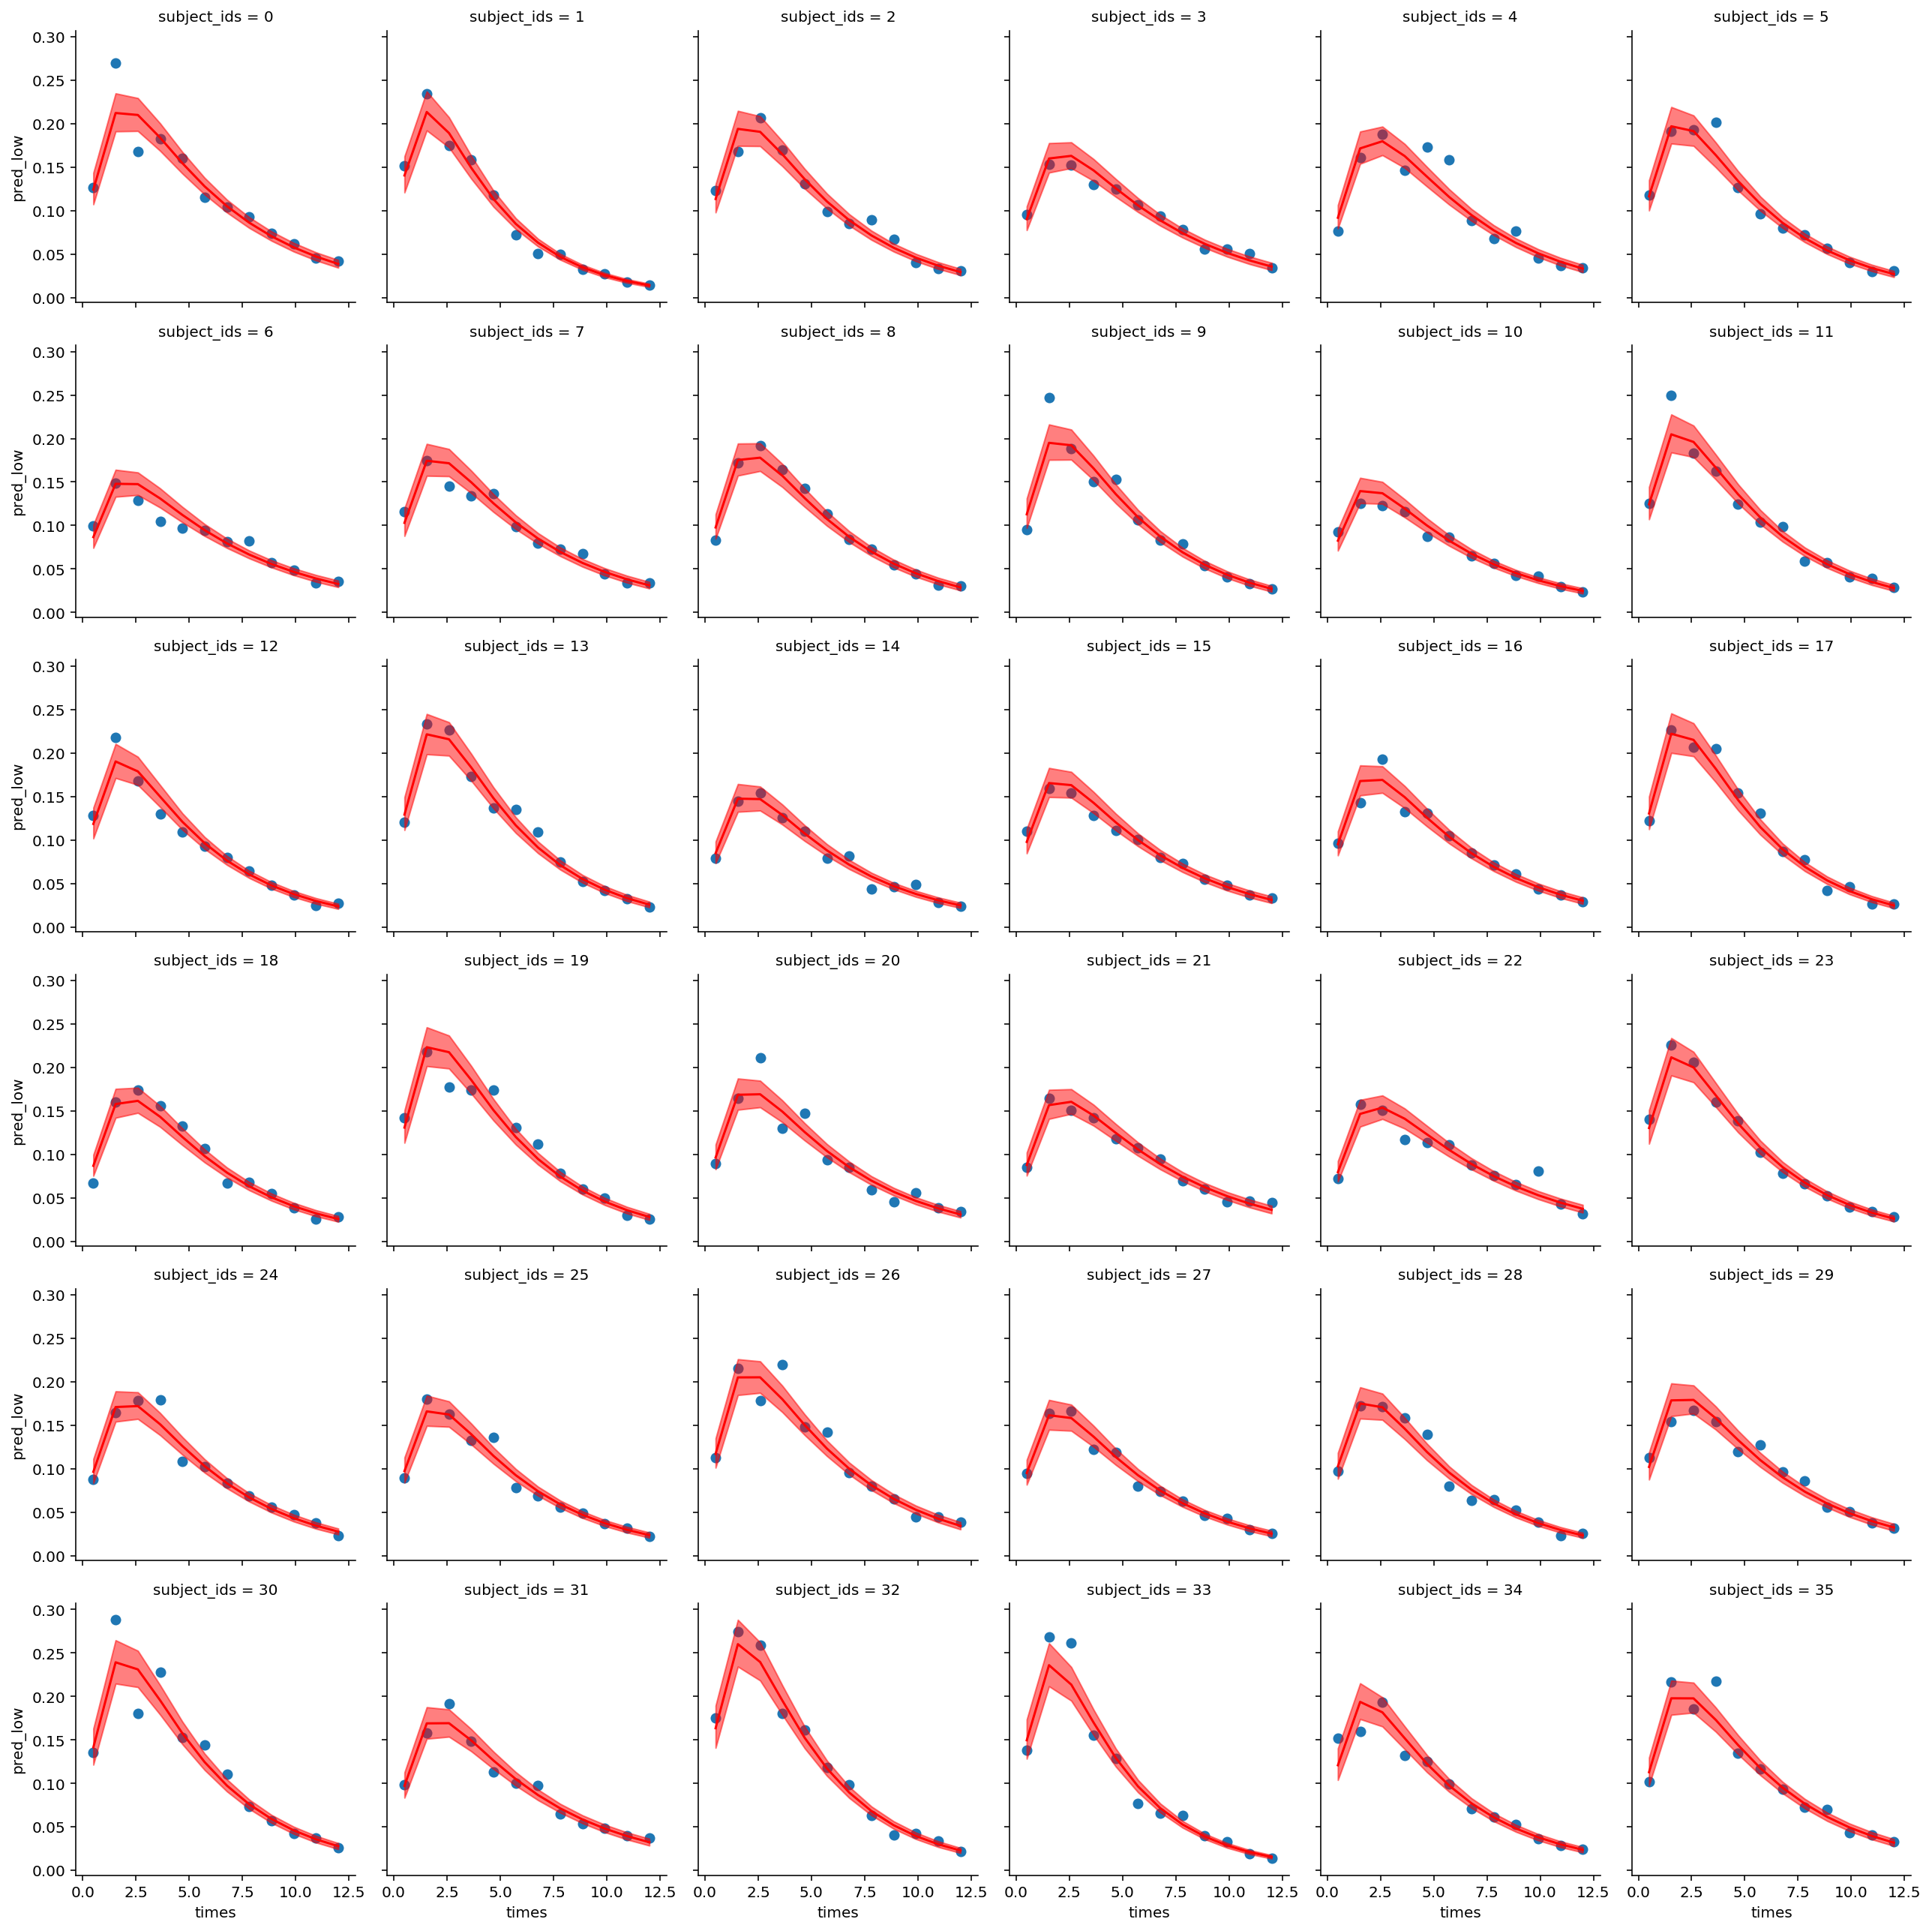

In [67]:
g = sns.FacetGrid(data = dfpred, col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'red')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'red')

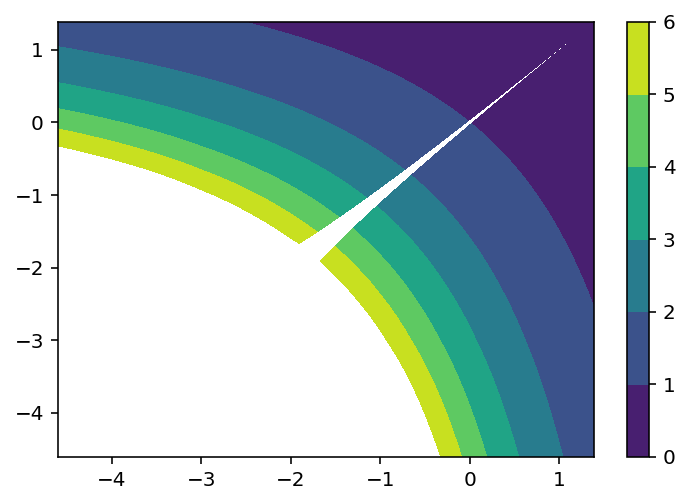

In [80]:
ka, ke = np.meshgrid(np.linspace(0.01, 4, 101),np.linspace(0.01, 4, 101))

tmax = np.log(ka/ke)/(ka-ke)

plt.contourf(np.log(ke),np.log(ka),tmax, levels = np.array([0,1,2,3,4,5,6]))

plt.colorbar()

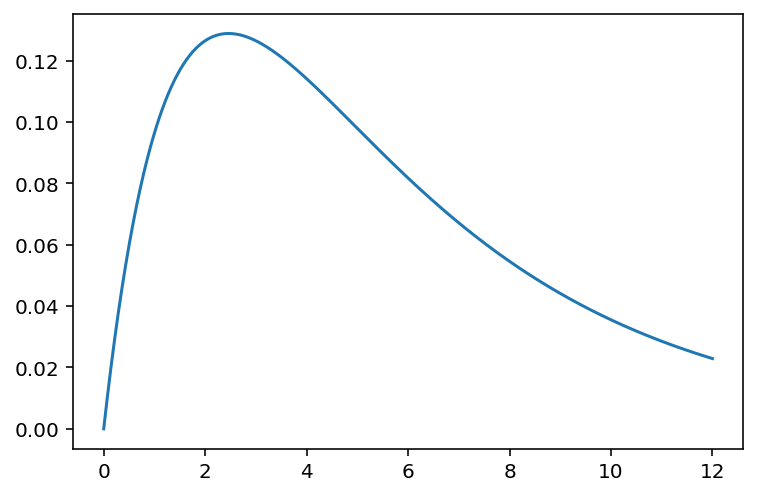

In [117]:
from scipy.integrate import odeint

t = np.linspace(0,12,1001)
def ode(y,t,ke,ka):
    return ke*ka*np.exp(-ka*t) - ke*y

Y = odeint(ode, t = t, y0 = 0, args = tuple([np.exp(-1.5), 3*np.exp(-1.5)]))

plt.plot(t,Y)

(array([  7.,  36.,  89., 192., 238., 235., 110.,  62.,  25.,   6.]),
 array([2.58551485, 2.67515231, 2.76478977, 2.85442723, 2.94406469,
        3.03370215, 3.12333961, 3.21297707, 3.30261453, 3.39225199,
        3.48188946]),
 <a list of 10 Patch objects>)

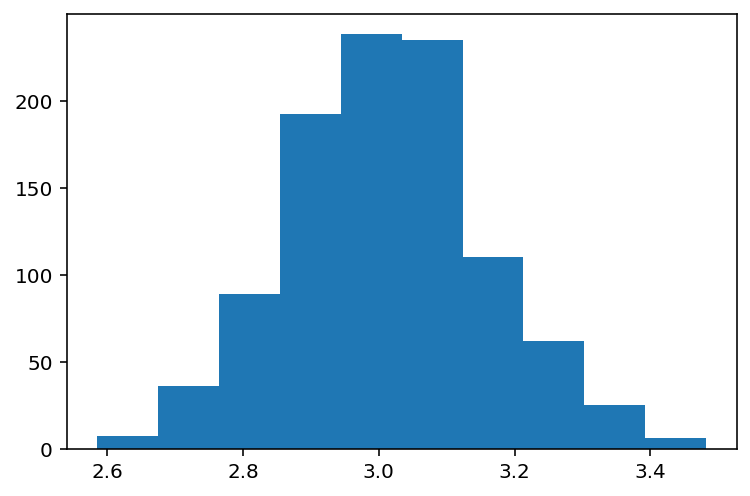

In [119]:
plt.hist(1/pm.Beta.dist(300,600).random(size =1000))